# ECSE 415 Final Project: Classification (35 Points)

Group 10 

April 2022

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

'''
Common google drive for project files and dataset. Mount with this drive.
email: ecse415project2022@gmail.com
password: mcgillecse415
'''

path = "/content/drive/MyDrive/ecse415-project/dataset"

Mounted at /content/drive


In [102]:
#The versus of cv2 needed is 4.4. As mentioned in Tutorial 4, the following command must be run to install the appropriate cv2 library.
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
import os
import random

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

from skimage.feature import hog
from skimage import exposure

import pickle
from google.colab.patches import cv2_imshow
from skimage.feature import hog
import pandas as pd

In [4]:
# Global Vars

RESIZE_WIDTH = 110
RESIZE_HEIGHT = 72
PIXEL_PER_CELL = 8

## Extract Images From Dataset

In [5]:
all_labels_0000 = np.load(os.path.join(path, 'all_labels_0000.npy'), allow_pickle=True)
all_images_0000 = np.load(os.path.join(path, 'all_images_0000.npy'), allow_pickle=True)

all_labels_0001 = np.load(os.path.join(path, 'all_labels_0001.npy'), allow_pickle=True)
all_images_0001 = np.load(os.path.join(path, 'all_images_0001.npy'), allow_pickle=True)

all_labels_0002 = np.load(os.path.join(path, 'all_labels_0002.npy'), allow_pickle=True)
all_images_0002 = np.load(os.path.join(path, 'all_images_0002.npy'), allow_pickle=True)

all_labels_0003 = np.load(os.path.join(path, 'all_labels_0003.npy'), allow_pickle=True)
all_images_0003 = np.load(os.path.join(path, 'all_images_0003.npy'), allow_pickle=True)

In [6]:
print(len(all_images_0000) == len(all_labels_0000))
print(len(all_images_0001) == len(all_labels_0001))
print(len(all_images_0002) == len(all_labels_0002))
print(len(all_images_0003) == len(all_labels_0003))

True
True
True
True


In [7]:
print(len(all_images_0000))
print(len(all_images_0001))
print(len(all_images_0002))
print(len(all_images_0003))
print("\n")

6262
30339
9590
4932




In [8]:
def view_labels(images, labels, number_to_predict):
  # Partially taken from: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
  w=20
  h=number_to_predict/2
  fig=plt.figure(figsize = (w,h))

  for i in range(1,number_to_predict + 1):
    img = cv2.resize(images[i], (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)

    fig.add_subplot(number_to_predict/5,5,i)
    plt.title(" Label: " + str(labels[i]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
  plt.show()

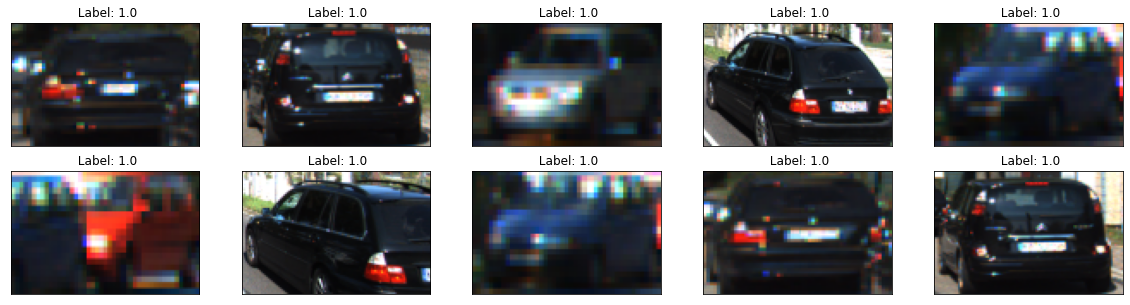

In [9]:
view_labels(all_images_0003, all_labels_0003, 10)

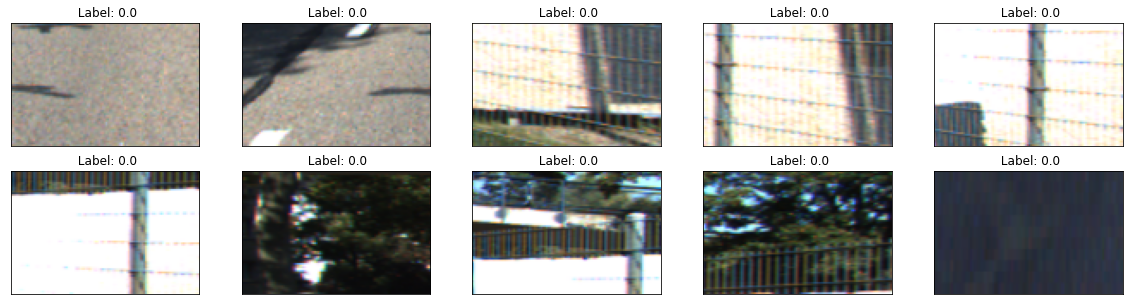

In [10]:
view_labels(list(reversed(all_images_0003)), list(reversed(all_labels_0003)), 10)

## HoG Features

In [11]:
def get_hog_features(img, orient=9, pixel_per_cell=8, cell_per_block=2, multichannel=True):
  """
  This function will extract the HoG features of the given img.
  """

  img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)
  #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # features = hog(img, orientations=orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell), cells_per_block=(cell_per_block, cell_per_block))

  cell_size = (pixel_per_cell, pixel_per_cell)   # h x w in pixels
  block_size = (cell_per_block, cell_per_block)  # h x w in cells THIS IS FOR NORMALIZATION
  nbins = orient  # number of orientation bins

  hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                img.shape[0] // cell_size[0] * cell_size[0]),
                      _blockSize=(block_size[1] * cell_size[1],
                                  block_size[0] * cell_size[0]),
                      _blockStride=(cell_size[1], cell_size[0]),
                      _cellSize=(cell_size[1], cell_size[0]),
                      _nbins=nbins)
  # hog = cv2.HOGDescriptor(_winSize=(1, 1),
  #                 _blockSize=(cell_per_block*pixel_per_cell, cell_per_block*pixel_per_cell),
  #                 _blockStride=(pixel_per_cell, pixel_per_cell),
  #                 _cellSize=(pixel_per_cell, pixel_per_cell),
  #                 _nbins=orient)

  features = hog.compute(img)

  return features

In [12]:
def extract_features(images, orient=9, pix_per_cell=8, cell_per_block=2):
  """
  This function returns a list of HoG features given a list of images
  """

  features = []
  for i, img in enumerate(images):
    feature_img = np.copy(img)
    feat = get_hog_features(feature_img, orient, pix_per_cell, cell_per_block)
    features.append(feat)
  
  return features

## Classifier Training and Validation Methods

In [13]:
def validation(images, labels, model):
  """
  This function will run the given model on the given images and compare
  the prediction with the given labels to return the accuracy, precision,
  recall, f1-score and confusion matrix.
  """

  predictions = np.empty(len(images), dtype=float)
  for i, img in enumerate(images):
    feat = get_hog_features(img, pixel_per_cell=PIXEL_PER_CELL)
    if feat is None:
      predictions[i] = 0.
      continue
    feat = feat.astype(float).reshape(1, -1)
    predictions[i] = model.predict(feat)

  acc = np.sum(predictions == labels) / len(labels)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

  cm = confusion_matrix(labels, predictions)

  return acc, precision, recall, f1, cm

In [14]:
def save_model(model, file_path):
  pickle.dump(model, open(file_path, 'wb'))

In [15]:
def train_and_get_results(hog_features, train_labels, val_images, val_labels, clf):
  """
  Given a list of hog_features (like output of "extract_features" function) and
  a list of labels corresponding to the label of the image represented by those
  hog features, this function will train the given classifier using that
  dataset.

  This function will then use that trained classifier and the given 
  validation/test images and labels to call the "validation" method and 
  return its ouput metrics.
  """

  X_train, y_train = np.concatenate(hog_features), np.concatenate(train_labels)
  X_train = X_train[:, :, 0]
  # Fit a per-column scaler
  # X_scaler = StandardScaler().fit(X_train)
  # Apply the scaler to X
  # X_train = X_scaler.transform(X_train)
  
  clf.fit(X_train, y_train)
  acc, precision, recall, f1, confusion_matrix = validation(val_images, val_labels, clf)

  return acc, precision, recall, f1, confusion_matrix, clf

In [16]:
def three_fold_validation(clf, model_name, model_dir_path, features, labels, test_images, test_labels):
  """
  Given:
    a classifier 
    a list of 3 different feature dataset with 3 different corresponding labels
    a list of 3 test images with corresponding labels that also represent
    the images from the 3 different features datasets

    model_name and model_dir_path will be used to save the output to a file
  
  This function will run 3 fold validation and return the acc, precision, recall
  and f1 scores for all 3 validation tests.

  It will also save the 3 validation models to the models directory so localizing
  and tracking files have access to them.
  """

  train_features_1 = [features[0], features[1]]
  train_labels_1 = [labels[0], labels[1]]

  train_features_2 = [features[0], features[2]]
  train_labels_2 = [labels[0], labels[2]]

  train_features_3 = [features[1], features[2]]
  train_labels_3 = [labels[1], labels[2]]

  print("Training 0000 & 0001")
  print("Testing 0002")
  acc01, precision01, recall01, f101, _, _ = train_and_get_results(train_features_1, train_labels_1, test_images[2], test_labels[2], clf)
  save_model(clf,  model_dir_path + str(model_name) + "_train01.pkl")

  print("Training 0000 & 0002")
  print("Testing 0001")
  acc02, precision02, recall02, f102, _, _ = train_and_get_results(train_features_2, train_labels_2, test_images[1], test_labels[1], clf)
  save_model(clf,  model_dir_path + str(model_name) + "_train02.pkl")

  print("Training 0001 & 0002")
  print("Testing 0000")
  acc12, precision12, recall12, f112, _, _ = train_and_get_results(train_features_3, train_labels_3, test_images[0], test_labels[0], clf)
  save_model(clf,  model_dir_path + str(model_name) + "_train12.pkl")

  return [
          [acc01, precision01, recall01, f101],
          [acc02, precision02, recall02, f102],
          [acc12, precision12, recall12, f112]
  ]


## 3 Fold Validation

The following section will perform 2 tasks at the same time. The first is tuning hyperparameters and the second will be exporting the validation classifiers we train to our drive. These exported trained models can then be imported by localization and tracking files.

Note that from the data we will export into a pandas DF, we will then be able to choose the classifiers that performed the best.

### Hyper-Parameter Tuning by 3 Fold validation


We will begin by tuning our HoG features using Logistic Regression since that does not have any hyperparameters and is quick.

We then tune SVM, and Random Forest.

NOTE THAT FOR ALL CALLS TO 3 FOLD VALIDATION FUNCTION, WE ARE SAVING THE MODELS!



#### Logistic Regression 3 fold validation and Hog Hyperparameters

HoG hyperparameters:
orient=9, cell_per_block=2


IMAGE_SHAPES = [(110, 72), (64,32), (128, 64), (256, 124)]


CELL_SIZE = [8, 16, 32]

In [ ]:
df = pd.DataFrame(columns=['AVG-F1', 'STD-F1', 'AVG-ACC', 'STD-ACC',
                           'AVG-PRE', 'STD-PRE', 'AVG-REC', 'STD-REC', 'HoG-Resize-Height', 'HoG-Resize-Width', 'HoG-cell-size', 'VectorSize', 'SVM-Kernel'])

In [ ]:
def add_results_to_df(results, model_kernel, hog_hyperparameters, df):
  results = np.array(results)
  df = df.append(
      {
        'AVG-F1' :              sum(results[:,3])/3,
        'STD-F1':               np.std(results[:,3]),
        'AVG-ACC':              sum(results[:,0])/3, 
        'STD-ACC':              np.std(results[:,0]),
        'AVG-PRE':              sum(results[:,1])/3, 
        'STD-PRE':              np.std(results[:,1]),
        'AVG-REC':              sum(results[:,2])/3, 
        'STD-REC':              np.std(results[:,2]),
        'HoG-Resize-Height':    hog_hyperparameters[0][0], 
        'HoG-Resize-Width':     hog_hyperparameters[0][1], 
        'HoG-cell-size':        hog_hyperparameters[2],
        'VectorSize':           hog_hyperparameters[1],
        'SVM-Kernel':           model_kernel
      }, ignore_index=True
  )
  return df

In [ ]:
# Takes around 10 min to run - make sure you save the output dataframe
# before closing Collab!

IMAGE_SHAPES = [(110, 72), (64,32), (128, 64), (256, 124)]
CELL_SIZE = [8, 16, 32]
# IMAGE_SHAPES = [(110, 72)]
# CELL_SIZE = [8]

for shape in IMAGE_SHAPES:
  for cell in CELL_SIZE:
    print("Running for shape: ", shape)
    print("Running for cell: ", cell)
    RESIZE_WIDTH = shape[0]
    RESIZE_HEIGHT = shape[1]
    PIXEL_PER_CELL = cell

    if shape[0] == 256:
      if cell == 8:
        continue

    features_0000 = extract_features(all_images_0000, pix_per_cell=cell)
    features_0001 = extract_features(all_images_0001, pix_per_cell=cell)
    features_0002 = extract_features(all_images_0002, pix_per_cell=cell)
    features_0003 = extract_features(all_images_0003, pix_per_cell=cell)

    if features_0000[0] == ():
      continue


    train_features = [features_0000, features_0001, features_0002]
    train_labels = [all_labels_0000, all_labels_0001, all_labels_0002]

    test_images = [all_images_0000, all_images_0001, all_images_0002]
    test_labels = [all_labels_0000, all_labels_0001, all_labels_0002]

    test_model = LogisticRegression(max_iter=100, random_state=0)
    results = three_fold_validation(test_model, "LR_" + str(shape) + "_" + str(cell), path + "/../models/tuning/", train_features, train_labels, test_images, test_labels)

    df = add_results_to_df(results, 'LR', [(RESIZE_HEIGHT, RESIZE_WIDTH), len(features_0000[0]), cell], df)

Running for shape:  (110, 72)
Running for cell:  8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (110, 72)
Running for cell:  16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (110, 72)
Running for cell:  32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (64, 32)
Running for cell:  8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (64, 32)
Running for cell:  16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (64, 32)
Running for cell:  32
Running for shape:  (128, 64)
Running for cell:  8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (128, 64)
Running for cell:  16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (128, 64)
Running for cell:  32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (256, 124)
Running for cell:  8
Running for shape:  (256, 124)
Running for cell:  16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

Running for shape:  (256, 124)
Running for cell:  32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

In [ ]:
# Be careful not to overwrite existing dataframe.

df.to_csv(path + "/../models/hog2.csv")

In [ ]:
df_loaded = pd.read_csv(path + "/../models/hog.csv")

In [ ]:
df_loaded

,Unnamed: 0,AVG-F1,STD-F1,AVG-ACC,STD-ACC,AVG-PRE,STD-PRE,AVG-REC,STD-REC,HoG-Resize-Height,HoG-Resize-Width,HoG-cell-size,VectorSize,SVM-Kernel
0,0,0.713627,0.013906,0.756569,0.015669,0.767125,0.021079,0.668476,0.031076,72,110,8,3456,LR
1,1,0.659569,0.021263,0.704956,0.020712,0.697799,0.039702,0.632450,0.062492,72,110,16,540,LR
2,2,0.619300,0.025236,0.665197,0.018742,0.645596,0.038621,0.604785,0.073906,72,110,32,72,LR
3,3,0.679936,0.009534,0.724476,0.012147,0.721313,0.027130,0.645619,0.035453,32,64,8,756,LR
4,4,0.649460,0.014507,0.692079,0.008036,0.673753,0.026170,0.630595,0.045980,32,64,16,108,LR
5,5,0.707101,0.013989,0.751793,0.015653,0.762793,0.020217,0.660382,0.031588,64,128,8,3780,LR
6,6,0.683958,0.018821,0.727897,0.017071,0.728828,0.042197,0.651674,0.063475,64,128,16,756,LR
7,7,0.637300,0.028403,0.684657,0.014326,0.672066,0.039715,0.616786,0.081638,64,128,32,108,LR
8,8,0.708889,0.018536,0.749251,0.021831,0.751111,0.031388,0.671640,0.014359,124,256,16,3240,LR
9,9,0.648055,0.005228,0.696824,0.020251,0.688743,0.031640,0.614704,0.032530,124,256,32,504,LR


#### SVM

Tests:

KERNEL = ['linear', 'rbf']

Note that this section takes a very long time to run. Each SVM model takes ~2 hours. Google collab will disconnect notebooks running randomly, so all the data for this section was run locally in .py files.

The df was uploaded to show results.

In [17]:
df = pd.DataFrame(columns=['AVG-F1', 'STD-F1', 'AVG-ACC', 'STD-ACC',
                           'AVG-PRE', 'STD-PRE', 'AVG-REC', 'STD-REC', 'SVM-Kernel'])

In [ ]:
# BEST HoG Hyperparameters

RESIZE_WIDTH = 110
RESIZE_HEIGHT = 72
PIXEL_PER_CELL=8

features_0000 = extract_features(all_images_0000, pix_per_cell=PIXEL_PER_CELL)
features_0001 = extract_features(all_images_0001, pix_per_cell=PIXEL_PER_CELL)
features_0002 = extract_features(all_images_0002, pix_per_cell=PIXEL_PER_CELL)
features_0003 = extract_features(all_images_0003, pix_per_cell=PIXEL_PER_CELL)

In [ ]:
train_features = [features_0000, features_0001, features_0002]
train_labels = [all_labels_0000, all_labels_0001, all_labels_0002]

test_images = [all_images_0000, all_images_0001, all_images_0002]
test_labels = [all_labels_0000, all_labels_0001, all_labels_0002]

In [ ]:
# Takes too long to run in Collab. Must download and run locally.

KERNEL_TYPE = ["RBF", "linear"]

for k in KERNEL_TYPE:
  print("Running for KernelType: ", k)

  test_model = SVC(kernel=k, random_state=0, C=c)

  results = three_fold_validation(test_model, "SVM_" + str(k), path + "/../models/tuning/", train_features, train_labels, test_images, test_labels)
  results = np.array(results)
  df = df.append(
    {
      'AVG-F1' :              sum(results[:,3])/3,
      'STD-F1':               np.std(results[:,3]),
      'AVG-ACC':              sum(results[:,0])/3, 
      'STD-ACC':              np.std(results[:,0]),
      'AVG-PRE':              sum(results[:,1])/3, 
      'STD-PRE':              np.std(results[:,1]),
      'AVG-REC':              sum(results[:,2])/3, 
      'STD-REC':              np.std(results[:,2]),
      'SVM-Kernel':           k,
    }, ignore_index=True
)

In [96]:
# Be careful not to overwrite existing dataframe.

df.to_csv(path + "/../models/svm2.csv")

In [97]:
df_loaded = pd.read_csv(path + "/../models/svm.csv")

In [101]:
# Data must be loaded in from local DataFrame

df_loaded

,Unnamed: 0,Unnamed: 0.1,AVG-F1,STD-F1,AVG-ACC,STD-ACC,AVG-PRE,STD-PRE,AVG-REC,STD-REC,SVM-Kernel
0,0,0.0,80.903333,1.180320,83.516667,1.060356,85.572667,2.650276,76.980000,4.489744,RBF
1,1,1.0,69.808000,0.979796,72.493333,1.201945,75.842333,2.472504,64.663667,4.559308,Linear


#### Random Forest

TESTS: 

CRITERION = ['gini', 'entropy']
MAX_DEPTH = [10, 50]

In [ ]:
df = pd.DataFrame(columns=['AVG-F1', 'STD-F1', 'AVG-ACC', 'STD-ACC',
                           'AVG-PRE', 'STD-PRE', 'AVG-REC', 'STD-REC', 'RF-criterion',])

In [ ]:
# BEST HoG Hyperparameters

RESIZE_WIDTH = 110
RESIZE_HEIGHT = 72
PIXEL_PER_CELL=8

features_0000 = extract_features(all_images_0000, pix_per_cell=PIXEL_PER_CELL)
features_0001 = extract_features(all_images_0001, pix_per_cell=PIXEL_PER_CELL)
features_0002 = extract_features(all_images_0002, pix_per_cell=PIXEL_PER_CELL)
features_0003 = extract_features(all_images_0003, pix_per_cell=PIXEL_PER_CELL)

In [ ]:
train_features = [features_0000, features_0001, features_0002]
train_labels = [all_labels_0000, all_labels_0001, all_labels_0002]

test_images = [all_images_0000, all_images_0001, all_images_0002]
test_labels = [all_labels_0000, all_labels_0001, all_labels_0002]

In [ ]:
# This takes 37 minutes to run. Can run in Google Collab 

CRITERION = ['gini', 'entropy']

for c in CRITERION:
  print("Running for criterion: ", c)

  test_model = clf = RandomForestClassifier(criterion=c, random_state=0, max_depth=10)

  results = three_fold_validation(test_model, "RF_" + str(c), path + "/../models/tuning/", train_features, train_labels, test_images, test_labels)
  results = np.array(results)
  df = df.append(
    {
      'AVG-F1' :              sum(results[:,3])/3,
      'STD-F1':               np.std(results[:,3]),
      'AVG-ACC':              sum(results[:,0])/3, 
      'STD-ACC':              np.std(results[:,0]),
      'AVG-PRE':              sum(results[:,1])/3, 
      'STD-PRE':              np.std(results[:,1]),
      'AVG-REC':              sum(results[:,2])/3, 
      'STD-REC':              np.std(results[:,2]),
      'RF-criterion':         c,
    }, ignore_index=True
  )

Running for criterion:  gini
Training 0000 & 0001
Testing 0002
Training 0000 & 0002
Testing 0001
Training 0001 & 0002
Testing 0000
Running for criterion:  entropy
Training 0000 & 0001
Testing 0002
Training 0000 & 0002
Testing 0001
Training 0001 & 0002
Testing 0000


In [ ]:
df.to_csv(path + "/../models/rf.csv")

In [ ]:
df_loaded = pd.read_csv(path + "/../models/rf.csv")

In [ ]:
df

,AVG-F1,STD-F1,AVG-ACC,STD-ACC,AVG-PRE,STD-PRE,AVG-REC,STD-REC,RF-criterion
0,0.754828,0.020742,0.786660,0.016663,0.792265,0.039873,0.726703,0.063102,gini
1,0.752510,0.016821,0.785773,0.012931,0.794698,0.041558,0.720467,0.059452,entropy


## View Images

In [ ]:
def visual_prediction(model, images, labels, hog, number_to_predict):
  # Partially taken from: https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
  w=20
  h=number_to_predict/2
  fig=plt.figure(figsize = (w,h))

  for i in range(1,number_to_predict + 1):
    img = cv2.resize(images[i], (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)
    feat = get_hog_features(img)
    feat = feat.astype(float).reshape(1, -1)
    prediction = model.predict(feat)

    fig.add_subplot(number_to_predict/5,5,i)
    plt.title("Prediction: " + str(prediction[0]) + " Label: " + str(labels[i]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
  plt.show()

In [ ]:
model_path = path + "/../models/SVM_rbf_train01.pkl"
model_svm_01 =  pickle.load(open(model_path, 'rb'))

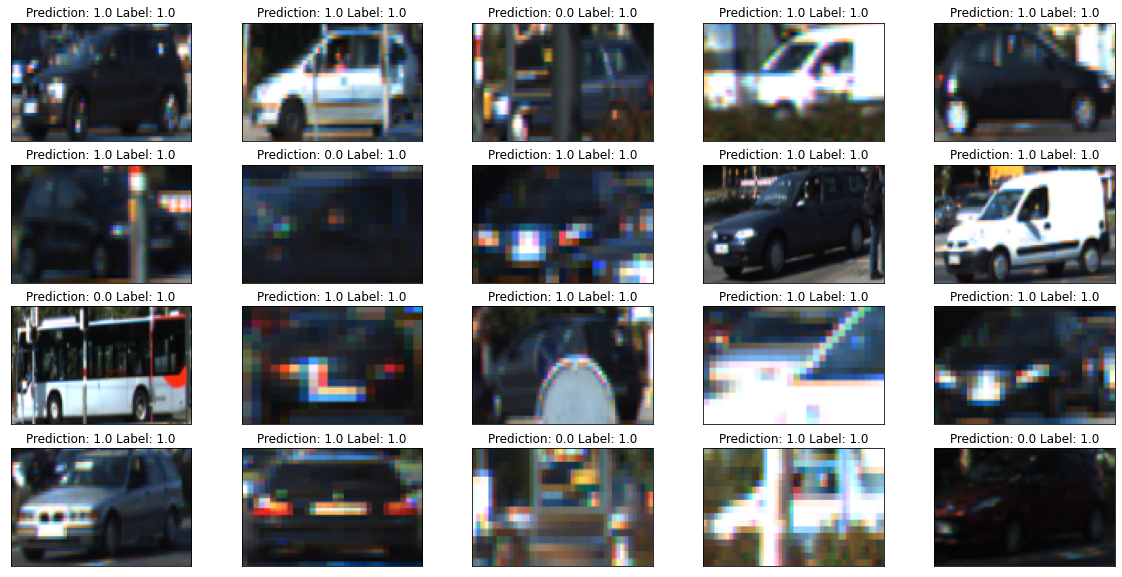

In [ ]:
visual_prediction(model_svm_01, all_images_0002, all_labels_0002, hog, 20)

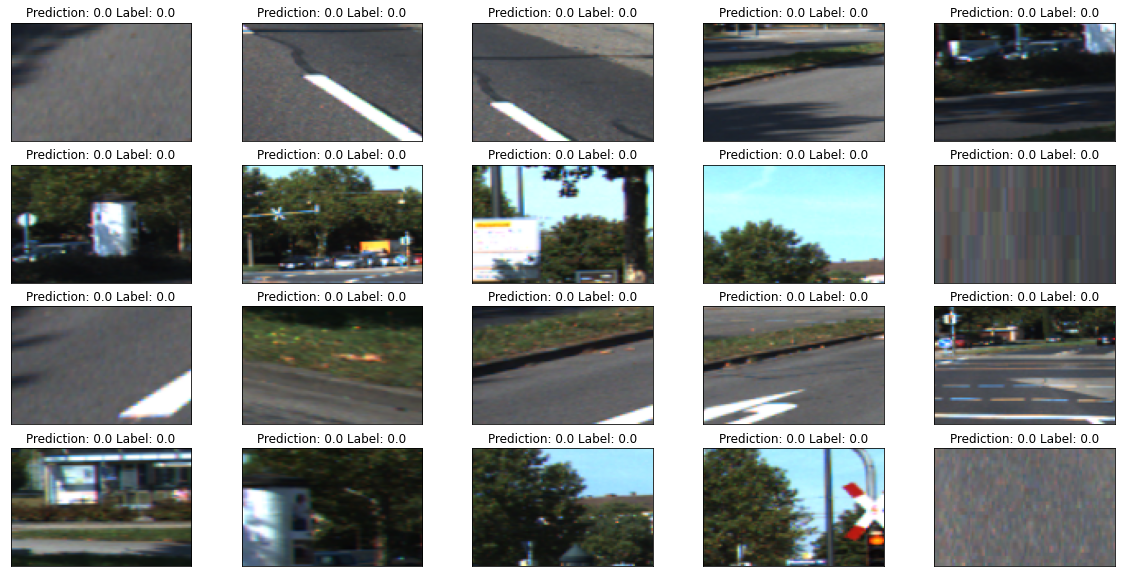

In [ ]:
visual_prediction(model_svm_01, list(reversed(all_images_0002)), list(reversed(all_labels_0002)), hog, 20)